### Import packages for data extraction and exploratory analysis

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
!pip install fredapi
from fredapi import Fred

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic


### Data Extraction (yf part, FRED to be included)

In [17]:
#S&P 500 (stock prices)
sp500 = yf.download("^GSPC",start="2000-01-01")[["Close"]]
sp500 = sp500.rename(columns={"Close": "SP500"})

# 3-month T-Bill (^IRX on Yahoo gives yield in %)
t3m = yf.download("^IRX", start="2000-01-01")[["Close"]]
t3m = t3m.rename(columns={"Close": "TBILL_3M"})

# 10-year Treasury yield (^TNX also in %)
t10y = yf.download("^TNX", start="2000-01-01")[["Close"]]
t10y = t10y.rename(columns={"Close": "YIELD_10Y"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Basic Data Inspection

In [18]:
print(sp500.head(), t3m.head(), t10y.head())
print(sp500.tail(), t3m.tail(), t10y.tail())
#print(sp500.describe(), t3m.describe(), t10y.describe())

Price             SP500
Ticker            ^GSPC
Date                   
2000-01-03  1455.219971
2000-01-04  1399.420044
2000-01-05  1402.109985
2000-01-06  1403.449951
2000-01-07  1441.469971 Price      TBILL_3M
Ticker         ^IRX
Date               
2000-01-03     5.27
2000-01-04     5.27
2000-01-05     5.27
2000-01-06     5.24
2000-01-07     5.22 Price      YIELD_10Y
Ticker          ^TNX
Date                
2000-01-03     6.548
2000-01-04     6.485
2000-01-05     6.599
2000-01-06     6.549
2000-01-07     6.504
Price             SP500
Ticker            ^GSPC
Date                   
2025-10-14  6644.310059
2025-10-15  6671.060059
2025-10-16  6629.069824
2025-10-17  6664.009766
2025-10-20  6738.899902 Price      TBILL_3M
Ticker         ^IRX
Date               
2025-10-14    3.853
2025-10-15    3.858
2025-10-16    3.853
2025-10-17    3.832
2025-10-20    3.803 Price      YIELD_10Y
Ticker          ^TNX
Date                
2025-10-14     4.022
2025-10-15     4.046
2025-10-16     3.976
20

### Resample to weekly frequence, Merge DF, Drop NaNs and Describing

In [22]:
FREQ  = "W-FRI"  # Weekly (Friday)

sp500_w = sp500.resample(FREQ).last()
t3m_w   = t3m.resample(FREQ).last()
t10y_w  = t10y.resample(FREQ).last()

data = sp500_w.join([t3m_w, t10y_w], how="inner").dropna()
data.columns = ["S&P500", "YIELD_3M", "YIELD_10Y"]

print(data.describe())
print(data.corr())

#data.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/raw_dataset.csv")

            S&P500     YIELD_3M    YIELD_10Y
count  1347.000000  1347.000000  1347.000000
mean   2238.806237     1.856754     3.306510
std    1410.759929     1.929487     1.294294
min     683.380005    -0.058000     0.536000
25%    1212.595032     0.090000     2.220500
50%    1519.790039     1.177000     3.395000
75%    2873.105103     3.595000     4.285500
max    6738.899902     6.190000     6.781000
             S&P500  YIELD_3M  YIELD_10Y
S&P500     1.000000  0.282850  -0.180562
YIELD_3M   0.282850  1.000000   0.749501
YIELD_10Y -0.180562  0.749501   1.000000


### Data Visualization

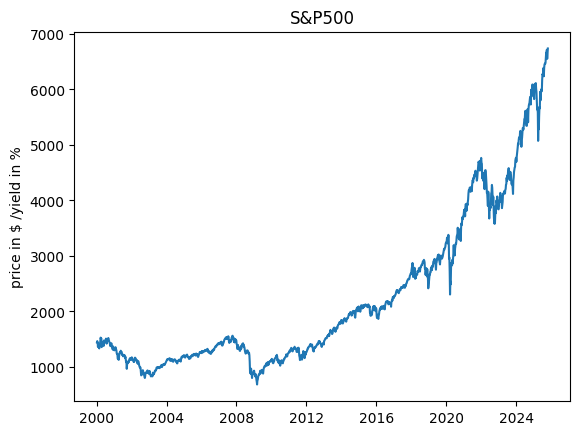

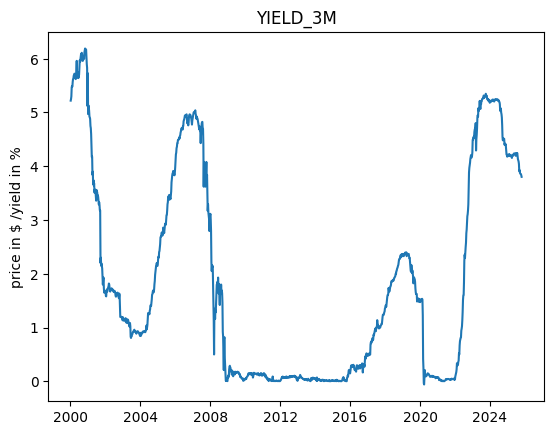

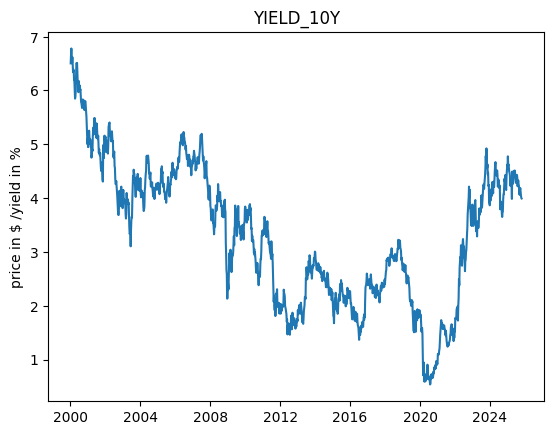

<Axes: >

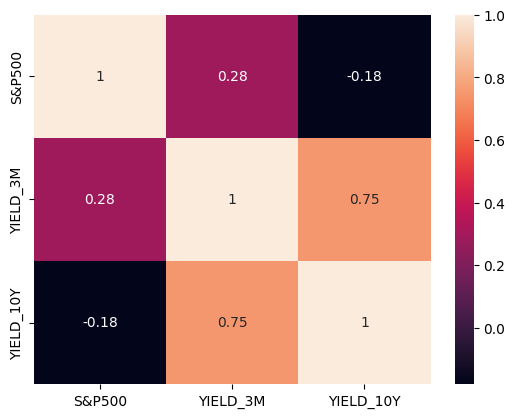

In [24]:
for column in data.columns:
    plt.plot(data[column], label=column)
    plt.title(column)
    plt.ylabel('price in $ /yield in %')
    plt.show()

sns.heatmap(data.corr(), annot=True)

### Data transformation (Log diffs)

In [38]:
data["r_t"] = np.log(data["S&P500"]).diff().dropna()
data["d_tbill"] = data["YIELD_3M"].diff().dropna()     # Δ i_t short-term
data["d_tbond"] = data["YIELD_10Y"].diff().dropna() # Δ i_t long-term

data_chg = data[["r_t", "d_tbill", "d_tbond"]]
#data_chg.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/data_chg.csv")

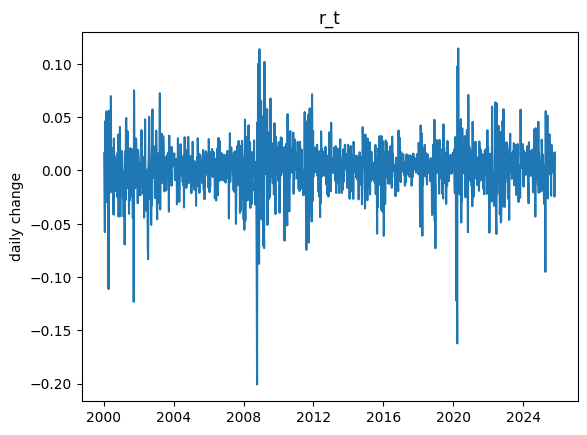

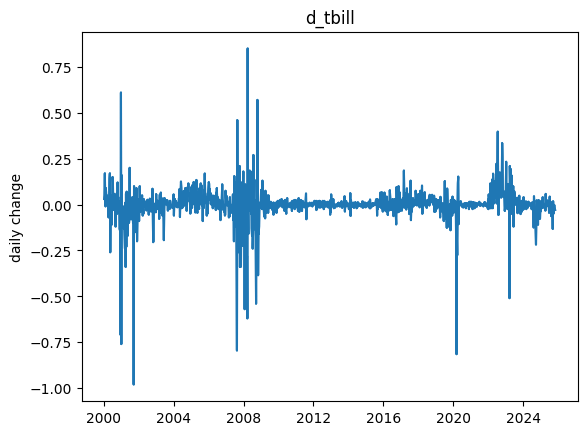

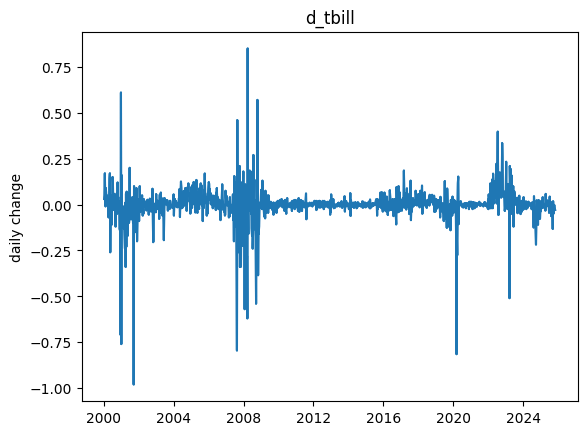

In [37]:
for column in data_chg.columns:
    plt.plot(data_chg[column], label=column, color=sns.color_palette()[0])
    plt.title(column)
    plt.ylabel('daily change')
    plt.show()